# Neural Network Regression with JAX and Optax

**Prepared for the Bank of Portugal Computational Economics Course (Oct 2025)**

**Author:** [John Stachurski](https://johnstachurski.net)

# Introduction

In a previous lecture, we showed how to implement regression using a neural
network via the deep learning library [Keras](https://keras.io/).

In this lecture, we solve the same problem directly, using JAX operations rather than relying on the Keras frontend.

The objective is to understand the nuts and bolts of the exercise better, as
well as to explore more features of JAX.

The lecture proceeds in three stages:

1. We repeat the Keras exercise, to give ourselves a benchmark.  
1. We solve the same problem in pure JAX, using pytree operations and gradient descent.  
1. We solve the same problem using a combination of JAX and [Optax](https://optax.readthedocs.io/en/latest/index.html), an optimization library build for JAX.  


We begin with imports and installs.

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
from time import time

In [2]:
#!pip install keras  # Uncomment if not installed

In [3]:
#!pip install optax  # Uncomment if not installed

In [4]:
os.environ['KERAS_BACKEND'] = 'jax'

(Without setting the backend to JAX, the imports below might fail – unless you have PyTorch or Tensorflow set up. If you have problems running the next cell in Jupyter, try quitting, running export KERAS_BACKEND="jax" and then starting Jupyter on the command line from the same terminal.)

In [5]:
import keras
from keras import Sequential
from keras.layers import Dense
import optax

## Set Up

Let’s hardcode some of the learning-related constants we’ll use across all
implementations.

In [6]:
class Config:
    epochs = 4000           # Number of passes through the data set
    data_size = 400         # Sample size
    num_layers = 4          # Depth of the network
    output_dim = 10         # Output dimension of input and hidden layers
    learning_rate = 0.001   # Learning rate for gradient descent

The next piece of code is repeated from our Keras lecture and generates the data.

In [7]:
def generate_data(x_min=0,           
                  x_max=5,          
                  data_size=Config.data_size,
                  seed=1234): # Default size for dataset
    np.random.seed(seed)
    x = np.linspace(x_min, x_max, num=data_size)
    ϵ = 0.2 * np.random.randn(data_size)
    y = x**0.5 + np.sin(x) + ϵ
    # Return observations as column vectors 
    x, y = [np.reshape(z, (data_size, 1)) for z in (x, y)]
    return x, y

## Training with Keras

We repeat the Keras training exercise from our earlier Keras lecture as a benchmark.

The code is essentially the same, although written slightly more succinctly.

Here is a function to build the model.

In [8]:
def build_keras_model(num_layers=Config.num_layers, 
                      output_dim=Config.output_dim,
                      activation_function='tanh'):
    model = Sequential()
    # Add layers to the network sequentially, from inputs towards outputs
    for i in range(num_layers-1):
        model.add(
           Dense(units=output_dim, 
                 activation=activation_function)
           )
    # Add a final layer that maps to a scalar value, for regression.
    model.add(Dense(units=1))
    # Embed training configurations
    model.compile(
        optimizer=keras.optimizers.SGD(), 
        loss='mean_squared_error'
    )
    return model

Here is a function to train the model.

In [9]:
def train_keras_model(
        model, x, y, x_validate, y_validate, epochs=Config.epochs):
    print(f"Training NN using Keras.")
    start_time = time()
    training_history = model.fit(
        x, y, 
        batch_size=max(x.shape), 
        verbose=0,
        epochs=epochs, 
        validation_data=(x_validate, y_validate)
    )
    elapsed = time() - start_time
    mse = model.evaluate(x_validate, y_validate, verbose=2)
    print(f"Trained Keras model in {elapsed:.2f} seconds with final MSE on validation data = {mse}")
    return model, training_history

The next function visualizes the prediction.

In [10]:
def plot_keras_output(model, x, y, x_validate, y_validate):
    y_predict = model.predict(x_validate, verbose=2)
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.plot(x, y_predict, label="fitted model", color='black')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

Here’s a function to run all the routines above.

In [11]:
def keras_run_all():
    model = build_keras_model()
    x, y = generate_data()
    x_validate, y_validate = generate_data()
    model, training_history = train_keras_model(
            model, x, y, x_validate, y_validate
    )
    plot_keras_output(model, x, y, x_validate, y_validate)

Let’s put it to work:

Training NN using Keras.


13/13 - 0s - 38ms/step - loss: 0.0409


Trained Keras model in 13.70 seconds with final MSE on validation data = 0.04094361513853073


13/13 - 0s - 16ms/step


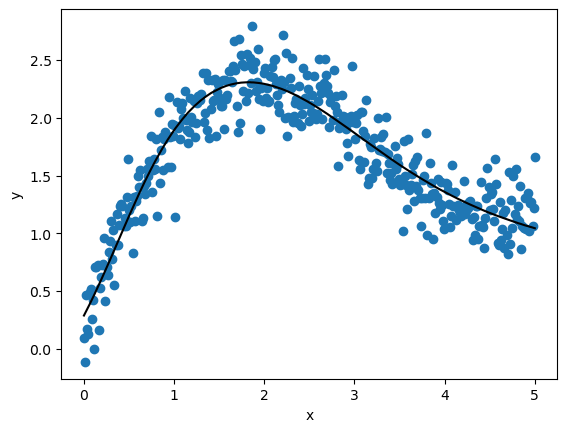

In [12]:
keras_run_all()

We’ve seen this figure before and we note the relatively low final MSE.

## Training with JAX

For the JAX implementation, we need to construct the network ourselves, as a map
from inputs to outputs.

We’ll use the same network structure we used for the Keras implementation.

### Background and set up

The neural network as the form

$$
f(\theta, x) 
    = (A_3 \circ \sigma \circ A_2 \circ \sigma \circ A_1 \circ \sigma \circ A_0)(x)
$$

Here

- $ x $ is a scalar input – a point on the horizontal axis in the Keras estimation above,  
- $ \circ $ means composition of maps,  
- $ \sigma $ is the activation function – in our case, $ \tanh $, and  
- $ A_i $ represents the affine map $ A_i x = W_i x + b_i $.  


Each matrix $ W_i $ is called a **weight matrix** and each vector $ b_i $ is called **bias** term.

The symbol $ \theta $ represents the entire collection of parameters:

$$
\theta = (W_0, b_0, W_1, b_1, W_2, b_2, W_3, b_3)
$$

In fact, when we implement the affine map $ A_i x = W_i x + b_i $, we will work
with row vectors rather than column vectors, so that

- $ x $ and $ b_i $ are stored as row vectors, and  
- the mapping is executed by JAX via the expression `x @ W + b`.  


We work with row vectors because Python numerical operations are row-major rather than column-major, so that row-based operations tend to be more efficient.

Here’s a function to initialize parameters.

The parameter “vector” `θ`  will be stored as a list of dicts.

In [13]:
def initialize_params(seed=1234):
    """
    Generate an initial parameterization for a feed forward neural network with
    number of layers = Config.num_layers.  
    Each of the hidden layers have Config.output_dim units.
    """
    k = Config.output_dim
    shapes = (
        (1, k),  # W_0.shape
        (k, k),  # W_1.shape
        (k, k),  # W_2.shape
        (k, 1)   # W_3.shape
    )   
    np.random.seed(seed)
    # A function to generate weight matrices
    def w_init(m, n):
        return np.random.normal(size=(m, n)) * np.sqrt(2 / m)
    # Build list of dicts, each containing a (weight, bias) pair
    θ = []
    for w_shape in shapes:
        m, n = w_shape
        θ.append(dict(W=w_init(m, n), b=np.ones((1, n))) )
    return θ

Wait, you say!

Shouldn’t we concatenate the elements of $ \theta $ into some kind of big array, so that we can do autodiff with respect to this array?

Actually we don’t need to, as will become clear below.

### Coding the network

Here’s our implementation of $ f $:

In [14]:
@jax.jit
def f(θ, x, σ=jnp.tanh):
    """
    Perform a forward pass over the network to evaluate f(θ, x).
    The state x is stored and iterated on as a row vector.
    """
    *hidden, last = θ
    for layer in hidden:
        W, b = layer['W'], layer['b']
        x = σ(x @ W + b)
    W, b = last['W'], last['b']
    x = x @ W + b
    return x 

The function $ f $ is appropriately vectorized, so that we can pass in the entire
set of input observations as `x` and return the predicted vector of outputs `y_hat = f(θ, x)`
corresponding  to each data point.

The loss function is mean squared error, the same as the Keras case.

In [15]:
@jax.jit
def loss_fn(θ, x, y):
    "Loss is mean squared error."
    return jnp.mean((f(θ, x) - y)**2)

We’ll use its gradient to do stochastic gradient descent.

(Technically, we will be doing gradient descent, rather than stochastic
gradient descent, since will not randomize over sample points when we
evaluate the gradient.)

The gradient below is with respect to the first argument `θ`.

In [16]:
loss_gradient = jax.jit(jax.grad(loss_fn))

The line above seems kind of magical, since we are differentiating with respect
to a parameter “vector” stored as a list of dictionaries containing arrays.

How can we differentiate with respect to such a complex object?

The answer is that the list of dictionaries is treated internally as a
[pytree](https://docs.jax.dev/en/latest/pytrees.html).

The JAX function `grad` understands how to

1. extract the individual arrays (the ``leaves’’ of the tree),  
1. compute derivatives with respect to each one, and  
1. pack the resulting derivatives into a pytree with the same structure as the parameter vector.

### Gradient descent

Using the above code, we can now write our rule for updating the parameters via gradient descent, which is the
algorithm we covered in our [lecture on autodiff](https://jax.quantecon.org/autodiff.html).

In this case, however, to keep things as simple as possible, we’ll use a fixed learning rate for every iteration.

In [17]:
@jax.jit
def update_parameters(θ, x, y, λ=Config.learning_rate):
    gradient = loss_gradient(θ, x, y)
    θ = jax.tree.map(lambda p, g: p - λ * g, θ, gradient)
    return θ

We are implementing the gradient descent update

    new_params = current_params - learning_rate * gradient_of_loss_function

This is nontrivial for a complex structure such as a neural network, so how is
it done?

The key line in the function above is 

    Θ = jax.tree.map(lambda p, g: p - λ * g, θ, gradient)

The `jax.tree.map` function understands `θ` and `gradient` as pytrees of the
same structure and executes `p - λ * g` on the corresponding leaves of the pair
of trees.

This means that each weight matrix and bias vector is updated by gradient
descent, exactly as required.

Here’s code that puts this all together.

In [18]:
def train_jax_model(
        θ, x, y, x_validate, y_validate, epochs=Config.epochs
    ):
    """
    Train model using gradient descent via JAX autodiff.
    """
    training_loss = np.empty(epochs)
    validation_loss = np.empty(epochs)
    for i in range(epochs):
        training_loss[i] = loss_fn(θ, x, y)
        validation_loss[i] = loss_fn(θ, x_validate, y_validate)
        θ = update_parameters(θ, x, y)
    return θ, training_loss, validation_loss

### Execution

Let’s run our code and see how it goes.

In [19]:
θ = initialize_params()
x, y = generate_data()
x_validate, y_validate = generate_data()

In [20]:
start_time = time()

θ, training_loss, validation_loss = train_jax_model(
    θ, x, y, x_validate, y_validate
)

elapsed = time() - start_time
print(f"Trained model with JAX in {elapsed:.2f} seconds.")

Trained model with JAX in 3.19 seconds.


This figure shows MSE across iterations:

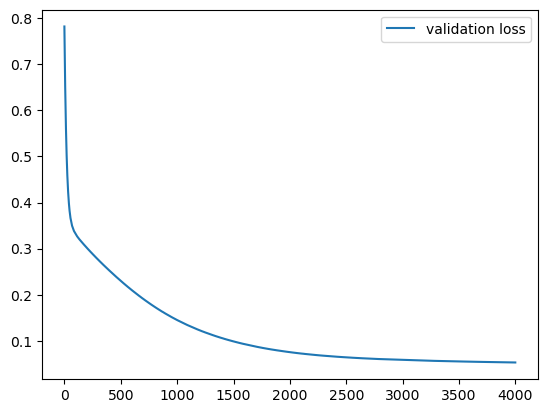

In [21]:
fig, ax = plt.subplots()
ax.plot(range(Config.epochs), validation_loss, label='validation loss')
ax.legend()
plt.show()

Let’s check the final MSE on the validation data, at the estimated parameters.

In [22]:
print(f"""
Final MSE on test data set = {loss_fn(θ, x_validate, y_validate)}.
"""
)


Final MSE on test data set = 0.05290459841489792.



This MSE is not as low as we got for Keras, but we did quite well given how
simple our implementation is.

Here’s a visualization of the quality of our fit.

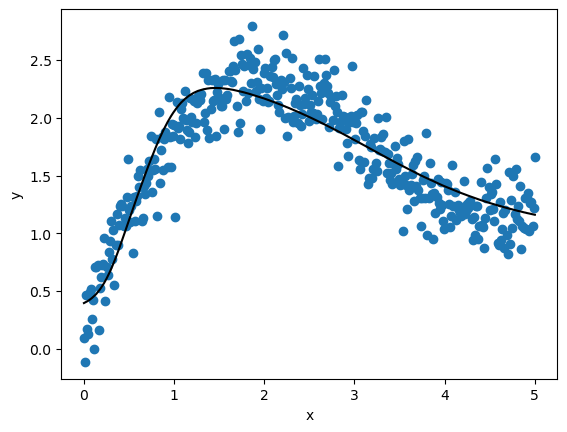

In [23]:
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x.flatten(), f(θ, x).flatten(), 
        label="fitted model", color='black')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

## JAX plus Optax

Our hand-coded optimization routine above was quite effective, but in practice
we might wish to use an optimization library written for JAX.

One such library is [Optax](https://optax.readthedocs.io/en/latest/).

### Optax with SGD

Here’s a training routine using Optax’s stochastic gradient descent solver.

In [24]:
def train_jax_optax(
        θ, x, y, epochs=Config.epochs, learning_rate=Config.learning_rate
    ):
    solver = optax.sgd(learning_rate)
    opt_state = solver.init(θ)
    for _ in range(epochs):
        grad = loss_gradient(θ, x, y)
        updates, opt_state = solver.update(grad, opt_state, θ)
        θ = optax.apply_updates(θ, updates)
    return θ

Let’s try running it.

In [25]:
# Reset parameter vector
θ = initialize_params()
# Train network

start_time = time()

θ = train_jax_optax(θ, x, y)

elapsed = time() - start_time
print(f"Trained model with JAX and Optax in {elapsed:.2f} seconds.")

Trained model with JAX and Optax in 7.90 seconds.


The resulting MSE is the same as our hand-coded routine.

In [26]:
print(f"""
Final MSE on test data set = {loss_fn(θ, x_validate, y_validate)}.
"""
)


Final MSE on test data set = 0.05290459841489792.



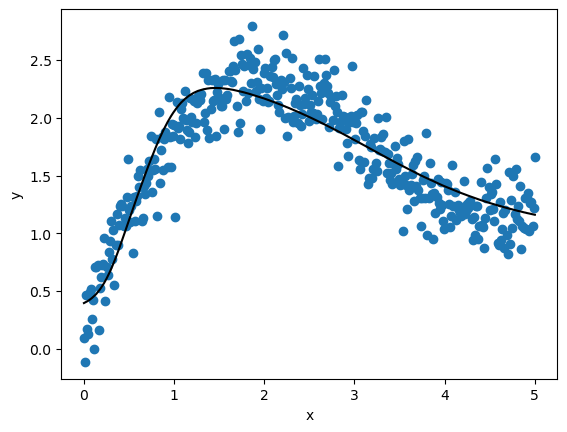

In [27]:
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x.flatten(), f(θ, x).flatten(), 
        label="fitted model", color='black')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

### Optax with ADAM

We can also consider using a slightly more sophisticated gradient-based method,
such as [ADAM](https://arxiv.org/pdf/1412.6980).

You will notice that the syntax for using this alternative optimizer is very
similar.

In [28]:
def train_jax_optax(
        θ, x, y, epochs=Config.epochs, learning_rate=Config.learning_rate
    ):
    solver = optax.adam(learning_rate)
    opt_state = solver.init(θ)
    for _ in range(epochs):
        grad = loss_gradient(θ, x, y)
        updates, opt_state = solver.update(grad, opt_state, θ)
        θ = optax.apply_updates(θ, updates)
    return θ

In [29]:
# Reset parameter vector
θ = initialize_params()
# Train network
start_time = time()

θ = train_jax_optax(θ, x, y)

elapsed = time() - start_time
print(f"Trained model with Optax and ADAM in {elapsed:.2f} seconds.")

Trained model with Optax and ADAM in 30.02 seconds.


Here’s the MSE.

In [30]:
print(f"""
Final MSE on test data set = {loss_fn(θ, x_validate, y_validate)}.
"""
)


Final MSE on test data set = 0.03738924115896225.



Here’s a visualization of the result.

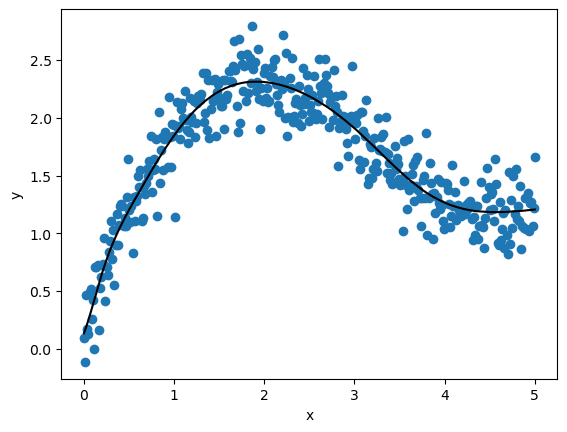

In [31]:
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x.flatten(), f(θ, x).flatten(), 
        label="fitted model", color='black')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()